# **Overview**

# **Library and Configurations**

In [ ]:
import sys
sys.path.append("..")

import importlib

from warnings import filterwarnings
filterwarnings('ignore')

# Core Library
import pandas as pd
import numpy as np
import math
from pathlib import Path

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Path tools
import os
import glob

# Computer vision tools
import cv2
import re

# Source code helper
import src.extraction as extraction
import src.cleaning as cleaning
import src.preprocessing as preprocessing
def r(module=extraction):
    importlib.reload(module)

r()

# Path
RAW_PATH = Path('../data/raw')
PROCESS_PATH = Path('../data/process')
CLEAN_PATH = Path('../data/clean')

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

print('Library Ready!')

Library Ready!


# **Plot Size Exploration**

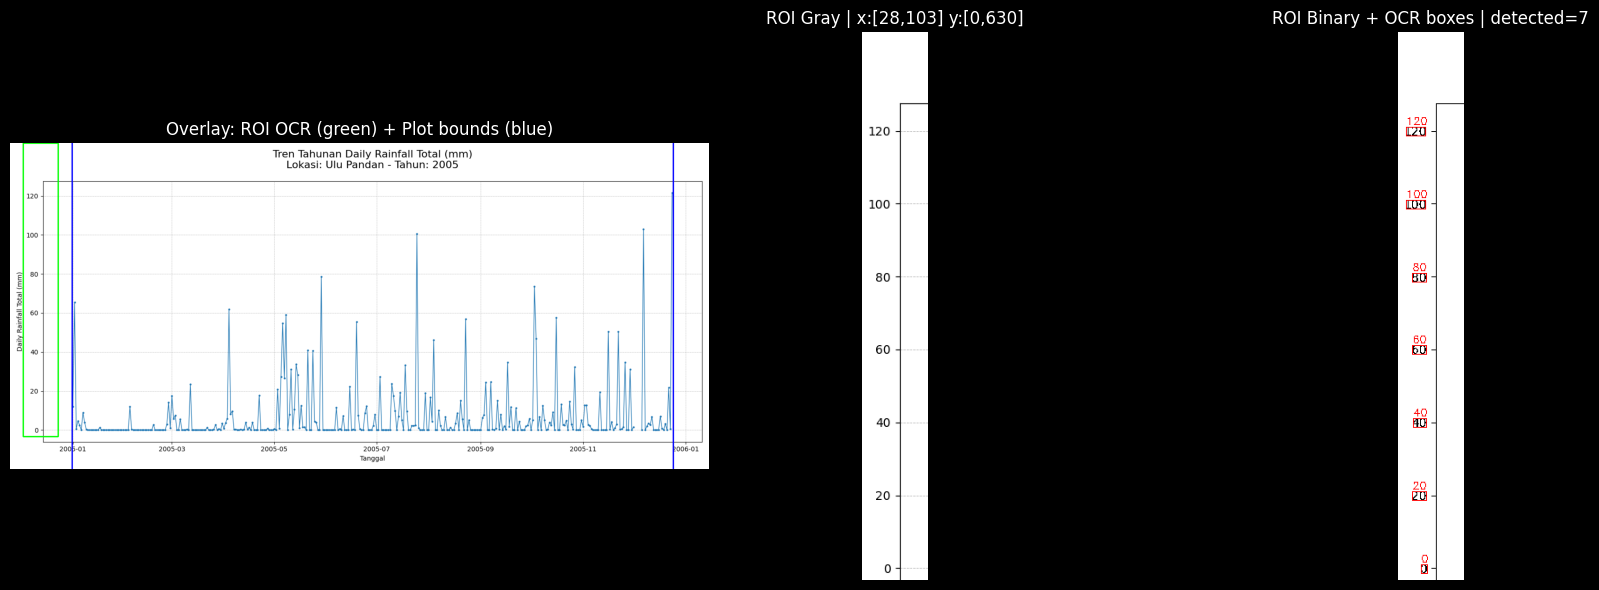

(28, 0, 103, 630)
['120', '100', '80', '60', '40', '20', '0']


In [3]:
def debug_y_label_ocr(
    image: np.ndarray,
    plot_x_start: int,
    plot_x_end: int,
    left_pad: int = 260,
    right_pad: int = 5,
    y_top_frac: float = 0.12,
    y_bot_frac: float = 0.95,
    show: bool = True
):
    h, w = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    y0 = int(h * y_top_frac)
    y1 = int(h * y_bot_frac)
    x1 = max(1, plot_x_start - right_pad)
    x0 = max(0, x1 - left_pad)

    roi = gray[y0:y1, x0:x1]
    roi_bin = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    data = pytesseract.image_to_data(
        roi_bin,
        config="--oem 3 --psm 6 outputbase digits",
        output_type=pytesseract.Output.DICT
    )

    det = []
    for i, txt in enumerate(data["text"]):
        txt = (txt or "").strip()
        if not txt:
            continue
        x, y, ww, hh = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        det.append((txt, x, y, ww, hh))

    overlay = image.copy()

    cv2.rectangle(overlay, (x0, y0), (x1, y1), (0, 255, 0), 2)

    cv2.line(overlay, (plot_x_start, 0), (plot_x_start, h-1), (255, 0, 0), 2)
    cv2.line(overlay, (plot_x_end, 0), (plot_x_end, h-1), (255, 0, 0), 2)

    roi_vis = cv2.cvtColor(roi_bin, cv2.COLOR_GRAY2BGR)
    for txt, x, y, ww, hh in det:
        cv2.rectangle(roi_vis, (x, y), (x+ww, y+hh), (0, 0, 255), 1)

        cv2.putText(roi_vis, txt, (x, max(10, y-3)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        axs[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Overlay: ROI OCR (green) + Plot bounds (blue)")
        axs[0].axis("off")

        axs[1].imshow(roi, cmap="gray")
        axs[1].set_title(f"ROI Gray | x:[{x0},{x1}] y:[{y0},{y1}]")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(roi_vis, cv2.COLOR_BGR2RGB))
        axs[2].set_title(f"ROI Binary + OCR boxes | detected={len(det)}")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "roi_coords": (x0, y0, x1, y1),
        "detected_texts": [t[0] for t in det],
        "num_boxes": len(det),
    }

sample_image = RAW_PATH/'Train/Ulu_Pandan/Plot_Daily_Rainfall_Total_mm_2005.png'
image = cv2.imread(str(sample_image))

info = debug_y_label_ocr(
    image,
    plot_x_start=133,
    plot_x_end=1423,
    left_pad= 75,     # seberapa jauh ROI melebar ke kiri dari plot_x_start
    right_pad= 30,      # jarak dari plot_x_start agar tidak kena garis axis
    y_top_frac= 0.0,
    y_bot_frac= 0.90,
    show= True
)
print(info["roi_coords"])
print(info["detected_texts"][:30])

# **Demo**


In [ ]:
    sample_image=RAW_PATH/'Train/Bukit_Panjang/Plot_Daily_Rainfall_Total_mm_2020.png'
image = cv2.imread(str(sample_image))

def find_data_boundaries(image: np.ndarray) -> dict:
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    blue_mask = cv2.inRange(
        hsv,
        np.array([100, 50, 30]),
        np.array([130, 255, 255])
    )

    contours, _ = cv2.findContours(
        blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        raise ValueError("No blue plot detected")

    x_coords = np.concatenate([cnt[:, 0, 0] for cnt in contours])

    return {
        "data_start": int(x_coords.min()),
        "data_end": int(x_coords.max())
    }

boundaries = find_data_boundaries(image)
boundaries

{'data_start': 133, 'data_end': 1423}

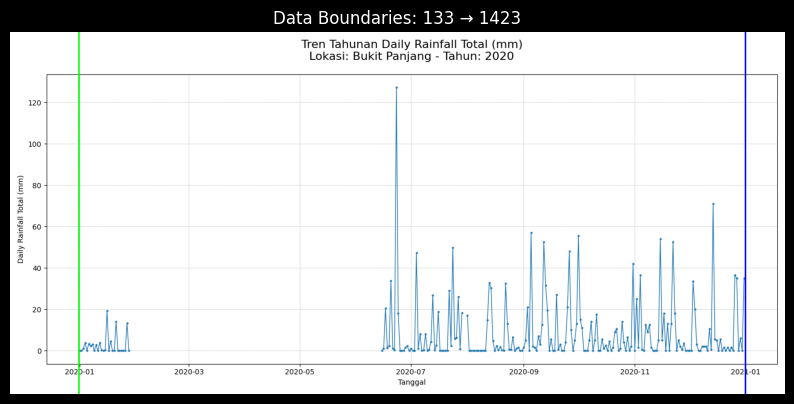

In [5]:
# Load image
image = cv2.imread(str(sample_image))
if image is None:
    raise FileNotFoundError(image_path)

# Your already-computed boundaries
data_start = boundaries["data_start"]
data_end = boundaries["data_end"]

# Draw boundaries
vis = image.copy()
h = vis.shape[0]

cv2.line(vis, (data_start, 0), (data_start, h), (0, 255, 0), 2)  # green
cv2.line(vis, (data_end, 0), (data_end, h), (255, 0, 0), 2)    # red

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Data Boundaries: {data_start} → {data_end}")
plt.axis("off")
plt.show()

In [6]:
def detect_plot_top_border(
    gray: np.ndarray,
    plot_x_start: int,
    plot_x_end: int,
    min_row: int = 10,
    occupancy_ratio: float = 0.20,
    binarize_thresh: int = 200
) -> int | None:
    """
    Detects the Y pixel position of the top plot border using
    horizontal projection of inverted binary image.

    Parameters
    ----------
    gray : np.ndarray
        Grayscale image.
    plot_x_start : int
        Left boundary of plot region.
    plot_x_end : int
        Right boundary of plot region.
    min_row : int, optional
        Rows above this index are ignored to avoid title/labels.
    occupancy_ratio : float, optional
        Minimum ratio of dark pixels required to detect border.
    binarize_thresh : int, optional
        Threshold value for binary inversion.

    Returns
    -------
    int | None
        Y pixel of detected top border, or None if not found.
    """

    plot_region = gray[:, plot_x_start:plot_x_end]

    _, binary_inv = cv2.threshold(
        plot_region,
        binarize_thresh,
        255,
        cv2.THRESH_BINARY_INV
    )

    row_projection = np.sum(binary_inv, axis=1)

    required_pixels = plot_region.shape[1] * occupancy_ratio * 255

    for y in range(min_row, len(row_projection)):
        if row_projection[y] > required_pixels:
            return y

    return None

def extract_y_axis_labels(
    image: np.ndarray,
    plot_x_start: int,
    plot_x_end: int,
    verbose: bool = True
) -> dict:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]

    # === ROI: match with your best debug settings ===
    left_pad   = 75
    right_pad  = 30
    y_top_frac = 0.0
    y_bot_frac = 0.90

    y0 = int(h * y_top_frac)
    y1 = int(h * y_bot_frac)
    x1 = max(1, plot_x_start - right_pad)
    x0 = max(0, x1 - left_pad)

    roi = gray[y0:y1, x0:x1]

    # binarize (same as debug)
    roi_bin = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    data = pytesseract.image_to_data(
        roi_bin,
        config="--oem 3 --psm 6 outputbase digits",
        output_type=pytesseract.Output.DICT
    )

    labels = []
    roi_w = roi.shape[1]
    x_cut = int(0.5 * roi_w)  # avoid axis line area (dynamic, not hardcoded 100)

    for i, txt in enumerate(data["text"]):
        txt = (txt or "").strip()
        if not txt.isdigit():
            continue

        val = int(txt)
        if val >= 200:
            continue

        x, y, ww, hh = data["left"][i], data["top"][i], data["width"][i], data["height"][i]

        # Skip boxes too far right inside ROI (often axis/grid noise)
        if x + ww > x_cut:
            continue

        # Optional: skip tiny garbage boxes
        if ww < 6 or hh < 8:
            continue

        # convert ROI coords -> global coords
        cx = x0 + x + ww / 2
        cy = y0 + y + hh / 2

        labels.append({"value": val, "x": cx, "y": cy})

    if len(labels) < 2:
        if verbose:
            detected = [t.strip() for t in data["text"] if (t or "").strip()]
            print("[DEBUG] ROI coords:", (x0, y0, x1, y1))
            print("[DEBUG] Raw detected texts (first 30):", detected[:30])
        raise ValueError("Insufficient Y-axis labels detected")

    labels_by_y = sorted(labels, key=lambda d: d["y"], reverse=True)

    uniq = []
    seen = set()
    for item in labels_by_y:
        if item["value"] in seen:
            continue
        uniq.append(item)
        seen.add(item["value"])
        if len(uniq) >= 2:
            break

    if len(uniq) < 2:
        raise ValueError("Need at least 2 distinct labels to estimate zero")

    low, high = uniq[0], uniq[1]  # low: bottom tick (largest y)
    dy = high["y"] - low["y"]
    dv = high["value"] - low["value"]

    if dv == 0:
        raise ValueError("Can't compute scale (dv=0)")

    pixel_per_unit = abs(dy) / abs(dv)

    # Predict y for 0 (same concept as before, but based on bottom tick)
    zero_y = low["y"] + low["value"] * pixel_per_unit
    labels.append({"value": 0, "x": low["x"], "y": float(zero_y)})

    # Extrapolate max using top border (keep your logic)
    top_border_y = detect_plot_top_border(gray, plot_x_start, plot_x_end)
    if top_border_y is not None:
        max_label = max(labels, key=lambda l: l["value"])
        delta_pixel = max_label["y"] - top_border_y
        max_value = max_label["value"] + delta_pixel / pixel_per_unit

        labels.append({"value": float(max_value), "x": max_label["x"], "y": float(top_border_y)})

        if verbose:
            print(f"[INFO] Extrapolated max value ≈ {max_value:.2f}")

    return {l["value"]: (l["x"], l["y"]) for l in sorted(labels, key=lambda l: l["value"])}


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
detect_plot_top_border(
    gray,
    plot_x_start = boundaries['data_start'],
    plot_x_end = boundaries['data_end'],
    min_row = 10,
    occupancy_ratio= 0.20,
    binarize_thresh = 200
)

labels=extract_y_axis_labels(image, plot_x_start=boundaries['data_start'], plot_x_end=boundaries['data_end'])
labels

[INFO] Extrapolated max value ≈ 133.75


{0: (57.5, 617.0),
 20: (52.0, 537.0),
 40: (52.5, 457.0),
 60: (52.0, 377.0),
 80: (52.0, 297.0),
 100: (48.0, 217.0),
 120: (48.0, 137.0),
 133.75: (48.0, 82.0)}

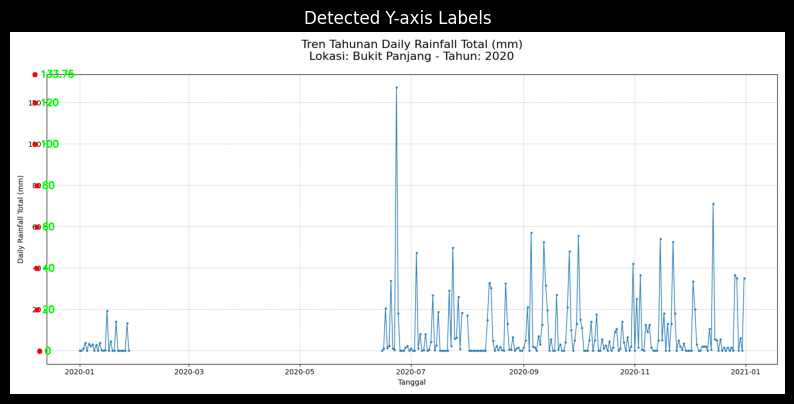

In [7]:
# Copy image for visualization
vis = image.copy()

# Draw labels
for value, (x, y) in labels.items():
    x, y = int(x), int(y)

    # Draw point
    cv2.circle(vis, (x, y), 5, (0, 0, 255), -1)

    # Draw text
    cv2.putText(
        vis,
        str(value),
        (x + 10, y + 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )

# Show result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Detected Y-axis Labels")
plt.axis("off")
plt.show()

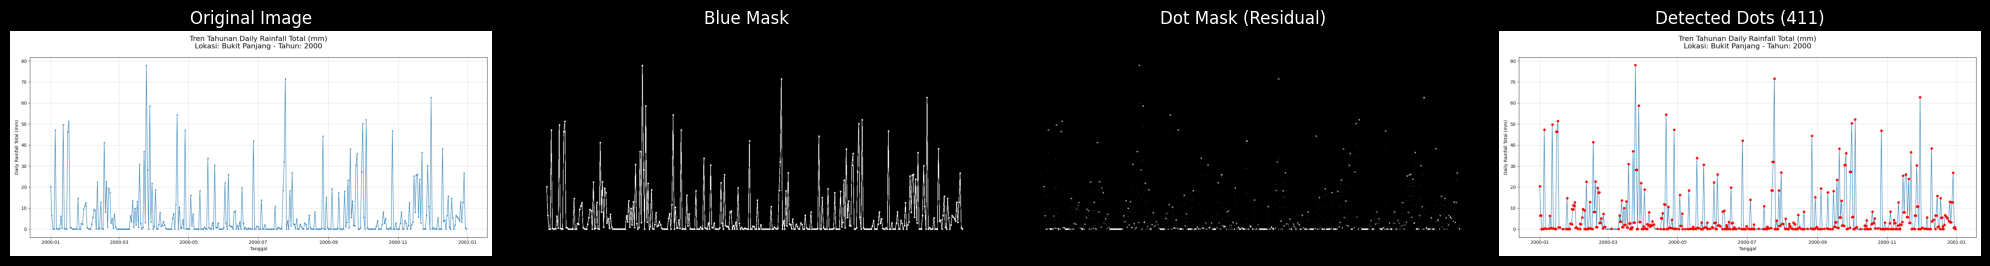

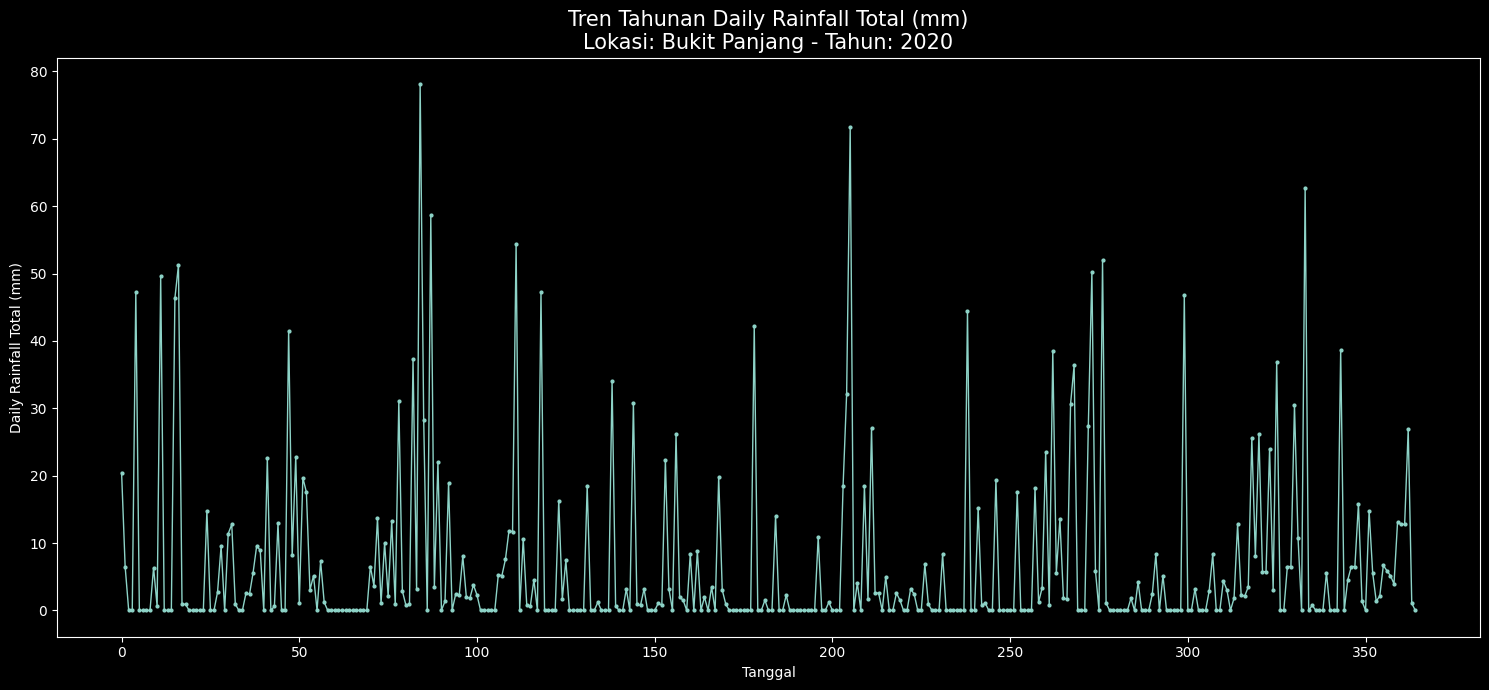

In [ ]:
r()

sample_image=RAW_PATH/'Train/Bukit_Panjang/Plot_Daily_Rainfall_Total_mm_2000.png'
image = cv2.imread(str(sample_image))

rainfall = extraction.extract_rainfall_from_plot(
    image_path=str(sample_image),
    total_days=365, debug=True
)

plt.figure(figsize=(15, 7))
plt.plot(rainfall, marker='o', linewidth=1, markersize=2)
plt.ylabel('Daily Rainfall Total (mm)')
plt.xlabel('Tanggal')

plt.title('Tren Tahunan Daily Rainfall Total (mm)\nLokasi: Bukit Panjang - Tahun: 2020', fontsize=15)
plt.tight_layout()
plt.show()

# **Chart Extraction**

In [ ]:
extraction.process_all_locations(
    input_root=RAW_PATH/'Train',
    output_dir=PROCESS_PATH/'extract',
    verbose=True
)

Extracting rainfall: 100%|██████████| 416121/416121 [23:00<00:00, 301.36rows/s]


# **Merge Extracted Data**

In [ ]:
train = extraction.build_training_dataset(
    features_dir=PROCESS_PATH/"merge/train/",
    targets_dir=PROCESS_PATH/"extract",
    output_csv=PROCESS_PATH/"train.csv"
)

Merging locations: 100%|██████████| 44/44 [00:01<00:00, 26.48it/s]



✅ Final training dataset saved to: ..\data\process\train.csv
   Rows: 416,121
   Columns: 11


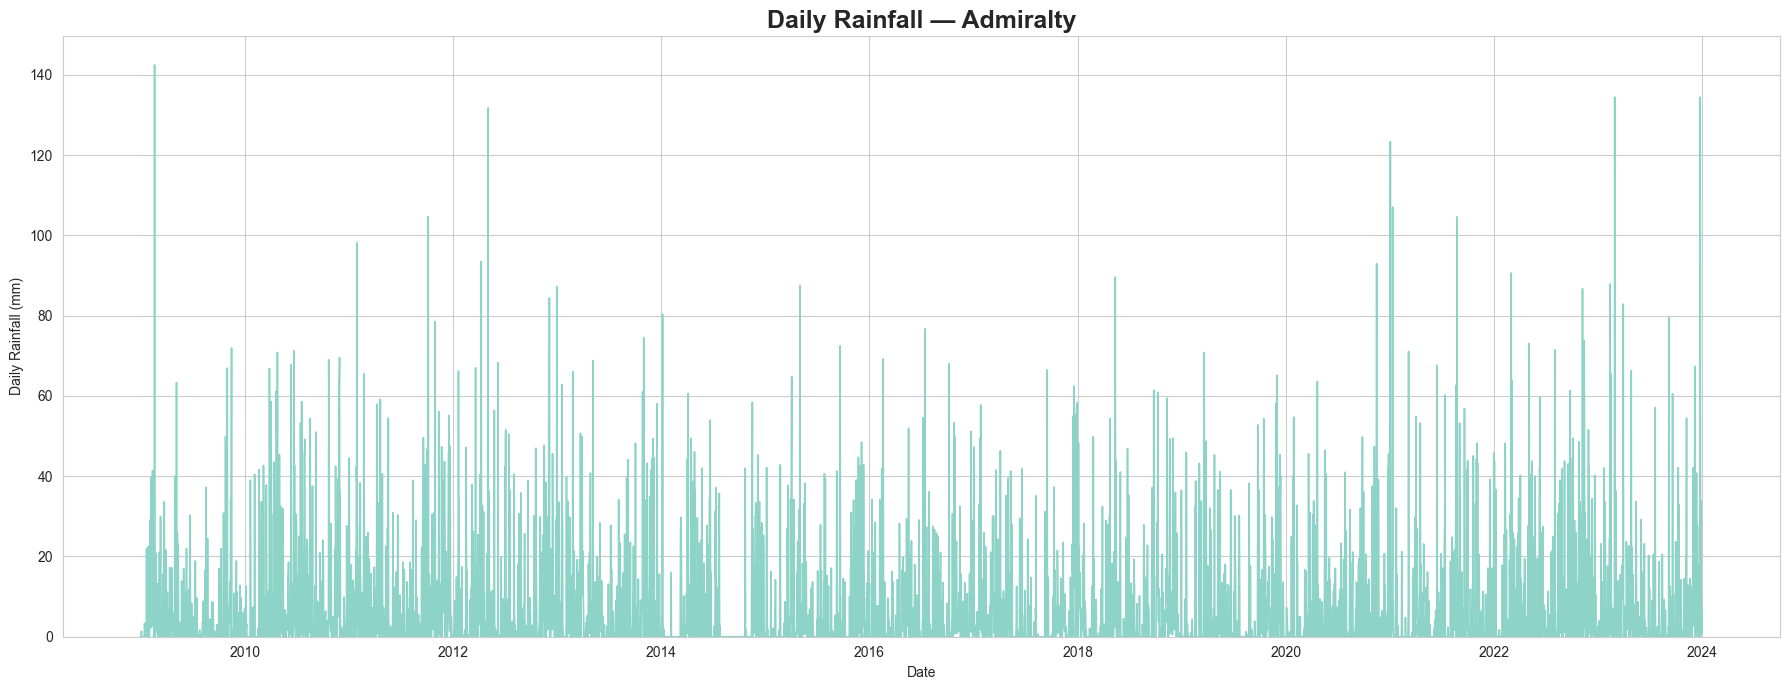

In [19]:
def plot_daily_rainfall_by_location(
    df: pd.DataFrame,
    location: str,
    *,
    save_path: str | Path | None = None,
    show: bool = True,
    figsize: tuple = (18, 7),
    style: str = "whitegrid"
):
    required_cols = {"date", "daily_rainfall_total_mm", "location"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df_loc = (
        df[df["location"] == location]
        .sort_values("date")
        .copy()
    )

    if df_loc.empty:
        available = sorted(df["location"].unique())
        raise ValueError(
            f"Location '{location}' not found.\nAvailable locations: {available}"
        )

    sns.set_style(style)
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        df_loc["date"],
        df_loc["daily_rainfall_total_mm"],
        linewidth=1.2
    )

    ax.set_title(
        f"Daily Rainfall — {location}",
        fontsize=18,
        fontweight="bold"
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Rainfall (mm)")
    ax.set_ylim(bottom=0)

    fig.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150)

    if show:
        plt.show()
    else:
        plt.close(fig)

def load_training_data(csv_path: str | Path) -> pd.DataFrame:
    csv_path = Path(csv_path)
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)

    return pd.read_csv(csv_path, parse_dates=["date"])


df = load_training_data(PROCESS_PATH/"train.csv")

plot_daily_rainfall_by_location(
    df,
    location="Admiralty"
)

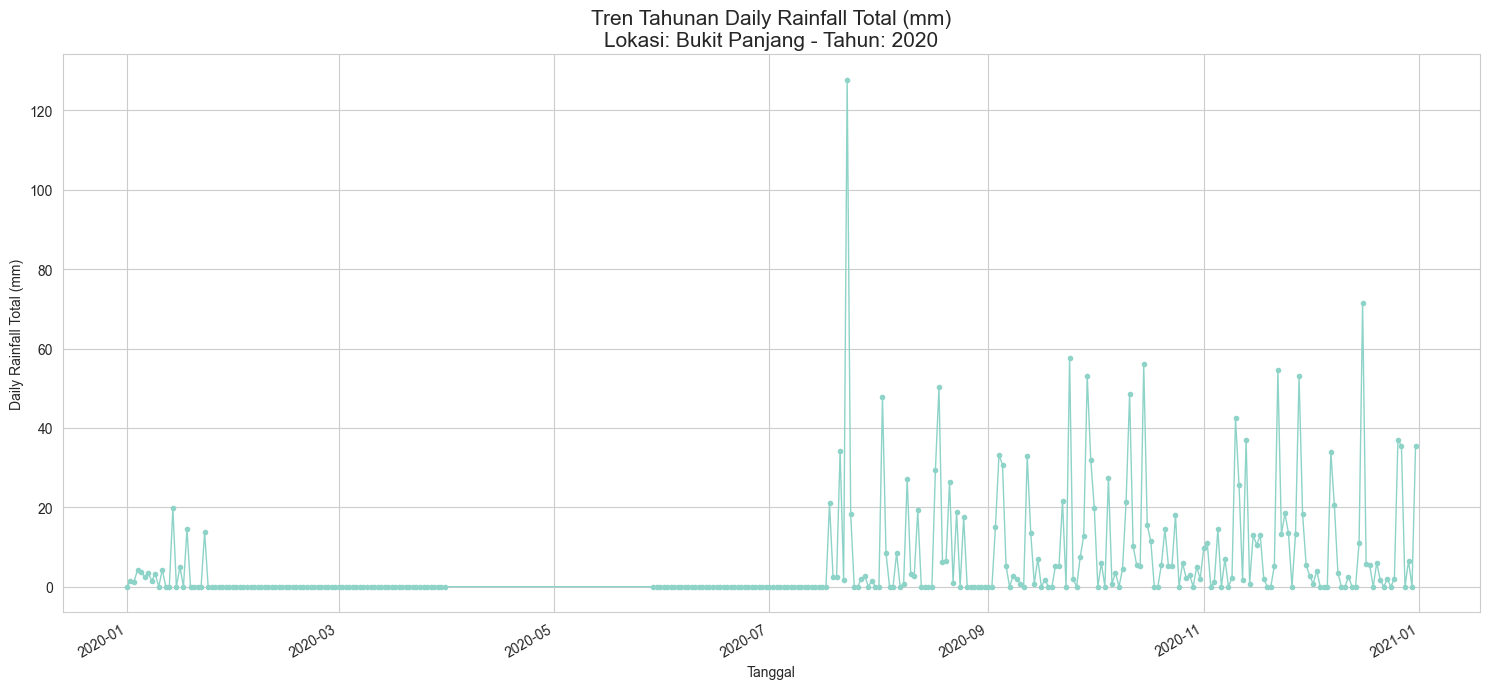

In [20]:
def plot_daily_rainfall_by_location_and_year(
    df: pd.DataFrame,
    location: str,
    year: int,
    *,
    save_path: str | Path | None = None,
    show: bool = True,
    figsize: tuple = (15, 7),
    style: str = "whitegrid"
):
    required_cols = {"date", "daily_rainfall_total_mm", "location"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df_loc = df[df["location"] == location].copy()
    if df_loc.empty:
        raise ValueError(
            f"Location '{location}' not found. "
            f"Available: {sorted(df['location'].unique())}"
        )

    df_year = df_loc[df_loc["date"].dt.year == year].sort_values("date")
    if df_year.empty:
        raise ValueError(f"No data for year {year} at location '{location}'")

    sns.set_style(style)
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        df_year["date"],
        df_year["daily_rainfall_total_mm"],
        linewidth=1,
        marker="o",
        markersize=3,
    )

    ax.set_title(
        f"Daily Rainfall — {location} ({year})",
        fontsize=15,
        fontweight="bold"
    )

    ax.set_ylabel('Daily Rainfall Total (mm)')
    ax.set_xlabel('Tanggal')

    ax.set_title('Tren Tahunan Daily Rainfall Total (mm)\nLokasi: Bukit Panjang - Tahun: 2020', fontsize=15)

    # Date formatting
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    fig.autofmt_xdate()

    fig.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150)

    if show:
        plt.show()
    else:
        plt.close(fig)


df = load_training_data(PROCESS_PATH/"train.csv")

plot_daily_rainfall_by_location_and_year(
    df,
    location="Bukit_Panjang",
    year=2020
)

In [21]:
folder_total = PROCESS_PATH/'train.csv'
lengkap = pd.read_csv(folder_total)
lengkap.head()

,date,highest_30_min_rainfall_mm,highest_60_min_rainfall_mm,highest_120_min_rainfall_mm,mean_temperature_c,maximum_temperature_c,minimum_temperature_c,mean_wind_speed_kmh,max_wind_speed_kmh,daily_rainfall_total_mm,location
0,2009-01-01,,,,,,,,,0.000000,Admiralty
1,2009-01-02,,,,,,,,,0.000000,Admiralty
2,2009-01-03,,,,,,,,,0.000000,Admiralty
3,2009-01-04,,,,,,,,,1.388889,Admiralty
4,2009-01-05,,,,,,,,,0.000000,Admiralty


In [22]:
lengkap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416121 entries, 0 to 416120
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         416121 non-null  object 
 1   highest_30_min_rainfall_mm   403151 non-null  object 
 2   highest_60_min_rainfall_mm   403148 non-null  object 
 3   highest_120_min_rainfall_mm  403151 non-null  object 
 4   mean_temperature_c           379428 non-null  object 
 5   maximum_temperature_c        380303 non-null  object 
 6   minimum_temperature_c        380263 non-null  object 
 7   mean_wind_speed_kmh          379149 non-null  object 
 8   max_wind_speed_kmh           379790 non-null  object 
 9   daily_rainfall_total_mm      416121 non-null  float64
 10  location                     416121 non-null  object 
dtypes: float64(1), object(10)
memory usage: 34.9+ MB


In [23]:
def load_data(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Input file not found: {path}")
    return pd.read_csv(path)


def save_data(df: pd.DataFrame, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)


def print_summary(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    converted_cols: list[str],
    output_path: Path,
) -> None:
    print("============ Data Cleaning Summary ============")
    print(f"Rows              : {len(df_after):,}")
    print(f"Columns converted : {len(converted_cols)}")
    print(f"Converted columns : {converted_cols}")
    print(f"Output file       : {output_path}")
    print("===============================================")


def main():
    print("Loading data...")
    df = load_data(PROCESS_PATH / "train.csv")
    df_before = df.copy()

    converted_cols = preprocessing.convert_numeric(df, df.select_dtypes(np.number).columns)
    cleaning.clean_column_names(df)
    save_data(df, CLEAN_PATH/"train.csv")

    print_summary(df_before, df, converted_cols, CLEAN_PATH/"train.csv")

if __name__ == '__main__':
    main()

Loading data...
============ Data Cleaning Summary ============
Rows              : 416,121
Columns converted : 1
Converted columns : ['daily_rainfall_total_mm']
Output file       : ..\data\clean\train.csv


In [ ]:
df['daily_rainfall_total_mm'].min() >= 0

np.True_